# Development of Kinematics Plotting
[uproot Getting Started](https://uproot.readthedocs.io/en/latest/basic.html)

In [1]:
import uproot
import matplotlib.pyplot as plt

In [2]:
with uproot.open('ntuple_tungsten_mAMeV_10_events_10000_run_3000.root:dbint/dbint') as t :
    df = t.arrays(library='pd')

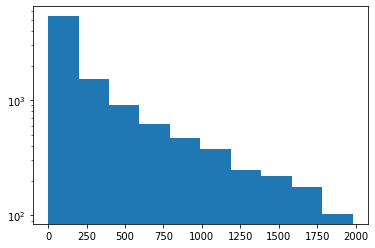

In [3]:
plt.hist(df['recoil_energy'])
plt.yscale('log')
plt.show()